<a href="https://www.kaggle.com/code/krist0phersmith/build-a-minigpt-for-text-generation?scriptVersionId=134953441" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ***WARNING*** 

## The data required to train the model for this task is known to be vulgar, offensive, toxic, racist, and otherwise not pleasant.
---

# MiniGPT For Generating Synthetic Text Data

## Problem Statement

Toxic comments online come in many forms and in many arenas. There are currently several ways to mitigate these comments(for those organizations who wish to do so). Some of these ways include human moderators, and training machine learning models to detect toxicity in online comments.

The issue with human moderators is that some of these platforms have grown so large so quickly that there are not nearly enough moderators to achieve any sense of control for most of these comments. The shear volume of toxicity and bots online makes it unrealistic to think we could do this job with humans at this point.

Many companies are employing machine learning to assist with identifying toxic comments online automatically. The problem with this approach is the lack of labeled training data to train the models on.

This is the problem I am going to solve using generative deep learning techniques. 

## References

* [Improving Language Understanding by Generative Pre-Training](https://www.semanticscholar.org/paper/Improving-Language-Understanding-by-Generative-Radford-Narasimhan/cd18800a0fe0b668a1cc19f2ec95b5003d0a5035)

* [Language Models are Unsupervised Multitask Learners](https://www.semanticscholar.org/paper/Language-Models-are-Unsupervised-Multitask-Learners-Radford-Wu/9405cc0d6169988371b2755e573cc28650d14dfe)

* [Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165)

* Many of the ideas and code were adapted from this Keras resource: https://keras.io/examples/generative/text_generation_with_miniature_gpt/

## Import Libraries

In [15]:
import os
import string
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk import ngrams
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

## set seeds for repeatable conclusion
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Data

The data I will be using to train the generative model was released on Kaggle as part of an ongoing series of competitions sponsored by the [Google company Jigsaw](https://en.wikipedia.org/wiki/Jigsaw_(company)).

The data consists of online comments with various severity levels of toxicity. There are versions of these comments labeled by human annotators wherein they label each comment as toxic or not, or other sets where they were labeled as different categories of toxic such as hatespeech, racist/sexist, obscene, etc. Although these are the labeled datasets we would be adding the synthetic data to in order to create more training data, for this task of simply generating similar text data we will only focus on the comments themselves.

The data provided by this competition includes a total of `14,251` unique toxic comments. Theses are the comments I will use to train the generative model with.

# EDA

The data came in two different files.

1) Comments to score: This acts as a test dataset of comments for scoring after the model was trained.

2) Validation data: This was the training data for the competition wherein there are two columns. One column labeled less toxic was a comment which human annotators labeled as less toxic than its more toxic counterpart in the other column. There was no actual training data where a comment was paired with its severity rating. The models were trained using creative techniques with the validation data and other classification data sets to train a model which predicted severity of comments.

Since for our purposes we are only interested in the actual text comments themselves, I will only be using those columns from these datasources.

I start by reading them all into pandas dataframes, isolating the text columns from each one, and stacking them all together so we have a single column of text when it is all said and done.


In [16]:
data1 = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')
data1.info()

## Isolate only text column
data1 = data1['text']

data1.sample(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7537 entries, 0 to 7536
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  7537 non-null   int64 
 1   text        7537 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.9+ KB


308     I dont not vandelise this place. Its the other...
1178    "\n\nPlease be more observant.  There is alrea...
7410     response to JamesBWatson \n\nThank you for yo...
6473    ok listen, I understand I probably went a litt...
2282    ": Reference is made to Bloom's homosexuality ...
7390     Blue Tits \n\nI saw a perfect example of a Bl...
Name: text, dtype: object

***We can see the comments to score was the test file which contained only comments and their corresponding id's***

In [17]:
data2 = pd.read_csv('../input/jigsaw-toxic-severity-rating/validation_data.csv')
data2.info()

data2.sample(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30108 entries, 0 to 30107
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   worker      30108 non-null  int64 
 1   less_toxic  30108 non-null  object
 2   more_toxic  30108 non-null  object
dtypes: int64(1), object(2)
memory usage: 705.8+ KB


,worker,less_toxic,more_toxic
6104,287,You are missing the point entirely. The kataka...,"YOU NONSENSE IS NOT RELEVENT, ROSKAM IS THE WI..."
15603,354,Wikipedia_talk:Censorship \n\nA watered-down ...,hi kannadiga shame on you \n\nYou look like a...
3063,633,"""\n\nJust wondering if EhuangZhang = Archaic_d...",EVERYONE WANTS TO KILL BILL GOD DAM GATES HE I...
12988,609,I have no life....I stay at home and customize...,"You are such a fucking faggot, there's no need..."
1121,110,Videos \n\nI don't think these videos are a g...,"""\n\n Human mind \n\n""""Firstly it relies on th..."
28427,49,"""\n\n Please do not vandalize pages, as you di...","""\n\nPersonal attack\nOh! do you know Portugu..."


In [18]:
data4 = pd.read_csv('../input/toxic-comment/jigsaw-toxic-comment-train.csv')
data4.info()

## Sum across labels to filter out clean comments
data4['sum'] = data4.loc[:, 'toxic':].sum(axis=1)

## Keep only comments with some type of label
data4 = data4[data4['sum'] > 0]

data4.sample(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum
9971,1a67395d931587cd,"And I GAVE you people sources, and that still ...",0,0,0,0,1,0,1
152451,8da589f13181621e,I will not even waste my time arguing with the...,1,0,0,0,1,0,2
99974,171623d2562e84df,"""\n\nyou're wrong; IAR applies to admins and r...",0,0,1,0,1,0,2
89677,efe99fac35b01d07,Diana is a fucking bitch nigger piece of shit,1,0,1,0,1,1,4
125331,9e6b70e0db26315b,A misery=\nYou have made my life a misery on W...,1,0,1,1,1,0,4
213235,d621a25e863f9263,This guy is a moron - a story of a fool,1,0,1,0,1,0,3


In [19]:
data5 = pd.read_csv('../input/toxic-comment/jigsaw-unintended-bias-train.csv')
data5.info()

drop_columns = [
    'created_date',
    'publication_id',
    'parent_id',
    'article_id', 
    'rating', 
    'funny', 
    'wow', 
    'sad', 
    'likes', 
    'disagree', 
    'identity_annotator_count', 
    'toxicity_annotator_count'
]

data5 = data5.drop(columns=drop_columns, axis=0)

## Sum across labels to filter out clean comments
data5['sum'] = data5.loc[:, 'toxic':].sum(axis=1)

## Keep only comments with some type of label
data5 = data5[data5['sum'] > 0]

data5.sample(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902194 entries, 0 to 1902193
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   comment_text                         object 
 2   toxic                                float64
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,sexual_explicit,sum
1547019,6015323,"See, Canadians love Trump!",0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.300000
391891,722718,"Mayor Coderre,Prime minister Couillard and Jus...",0.200000,0.0,0.0,0.000000,0.200000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.400000
1279758,5678347,Blah blah blah.. more whining from people unab...,0.628571,0.0,0.1,0.128571,0.585714,0.028571,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014286,1.485714
337732,656678,Do you have nothing else to do? You wait all y...,0.400000,0.0,0.0,0.000000,0.400000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.800000
796058,5094813,ANILCA was sought in the 70s to protect certai...,0.166667,0.0,0.0,0.000000,0.166667,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333
252747,552754,Aloha IBrakeForBirds!\n\nThe problem is your u...,0.100000,0.0,0.0,0.000000,0.000000,0.100000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.200000


***This was the data provided to validate the models performance during training. The three columns are workers(annotators) and the other two are text columns which we will use both to train our generative model with.***

### Combine all columns into a single column

In [20]:
## Isolate text column
data2 = data2['more_toxic']
data4 = data4['comment_text']
data5 = data5['comment_text']

## Isolate text column
data3 = pd.read_csv('../input/jigsaw-toxic-severity-rating/validation_data.csv')
data3 = data3['less_toxic']

text_column = pd.concat([data1, data2, data3, data4, data5], axis=0, ignore_index=True)

### Check for duplicates

In [21]:
text_column.value_counts()

Nonsense.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              47
The domestic terrorists at the company called "civil comments" are attempting to destroy your first amendment right to free speech!\nOnly in communist countries or in Nazi Germany you had to have approval of your speech by your peers!\nThat's not the Uni

It looks like between the data provided for the competition there are many duplicates. However we can see that some comments are reused many more times than other comments. For example the most used comments were repeated `19` times in the datasets while others only `2` times. 

Since the duplications are not balanced if we left the data like this I am afraid we would be biasing the model towards the comments which were present more in the data. 

I will remove all duplicate comments.

In [22]:
print(f"Total numer of comments in text data = {len(text_column)}")
print(f"Numer of unique comments in text data = {len(text_column.unique())}")

text_column = text_column.drop_duplicates()
print("Duplicate comments dropped")

Total numer of comments in text data = 797522
Numer of unique comments in text data = 735613
Duplicate comments dropped


### Exploring the toxic comments

In [23]:
data = pd.DataFrame()
data['text'] = text_column
data = data.sample(100)

# Function to calculate word count
def count_words(text):
    words = nltk.word_tokenize(text)
    return len(words)

# Function to calculate verb count
def count_verbs(text):
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words)
    verb_count = len([word for word, tag in tagged_words if tag.startswith('V')])
    return verb_count

# Function to calculate noun count
def count_nouns(text):
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words)
    noun_count = len([word for word, tag in tagged_words if tag.startswith('N')])
    return noun_count

# Add word count column
data['word_count'] = data['text'].apply(count_words)

# Add verb count column
data['verb_count'] = data['text'].apply(count_verbs)

# Add noun count column
data['noun_count'] = data['text'].apply(count_nouns)

data.describe()

,word_count,verb_count,noun_count
count,100.000000,100.000000,100.000000
mean,74.950000,11.800000,17.930000
std,59.605161,10.060424,14.787556
min,5.000000,0.000000,1.000000
25%,27.750000,4.000000,6.000000
50%,52.500000,8.000000,12.000000
75%,113.000000,18.000000,25.500000
max,219.000000,38.000000,60.000000


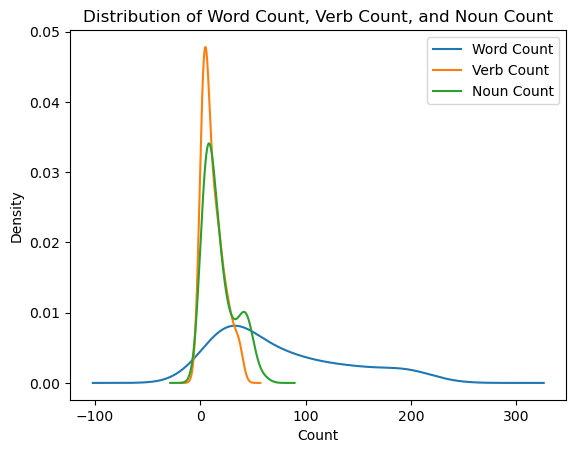

In [24]:
ax = data['word_count'].plot(kind='kde')
data['verb_count'].plot(kind='kde', ax=ax)
data['noun_count'].plot(kind='kde', ax=ax)

ax.legend(['Word Count', 'Verb Count', 'Noun Count'])
ax.set_title('Distribution of Word Count, Verb Count, and Noun Count')
ax.set_xlabel('Count')
ax.set_ylabel('Density')

plt.show()

We can see that these comments on average are quite short in length and contain more nouns than verbs on average.

Since we have not done any cleaning of the data yet these distributions are not exact as the nltk package is not currently looking for misspelled words or different versions of word spellings which are used online sometimes.

For example if a user knows that the platform they are on has limitations on language than they may spell a profane word to try to fool any auto detecting systems such as `Fuck==>Fxck, F*ck, Fukk, Fuuu*uukk`, etc.

Therefore these counts will not detect all nouns and verbs but should give a decent sample.

Knowing the underlying distributions of some of these features is important because after the synthetic data is generated we would most likely want it to follow the same distributions for these attributes of the text. 

### Looking at the most common N-grams

In [25]:
# Tokenize the text into words
data['words'] = data['text'].apply(nltk.word_tokenize)

# Get bigrams and trigrams for each row
data['bigrams']   = data['words'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams']  = data['words'].apply(lambda x: list(ngrams(x, 3)))
# data['quadgrams'] = data['words'].apply(lambda x: list(ngrams(x, 4)))

# Count the occurrences of bigrams and trigrams
bigram_counts   = Counter([gram for grams in data['bigrams'] for gram in grams])
trigram_counts  = Counter([gram for grams in data['trigrams'] for gram in grams])
# quadgram_counts = Counter([gram for grams in data['quadgrams'] for gram in grams])

# Get the most common bigrams, trigrams, and quadgrams
most_common_bigrams   = bigram_counts.most_common(50)
most_common_trigrams  = trigram_counts.most_common(50)
# most_common_quadgrams = quadgram_counts.most_common(50)

df_common_grams = pd.DataFrame()
df_common_grams['bigrams']   = most_common_bigrams
df_common_grams['trigrams']  = most_common_trigrams
# df_common_grams['quadgrams'] = most_common_quadgrams

# # Display the results
# print('Most common bigrams:')
# for bigram, count in most_common_bigrams:
#     print(' '.join(bigram), count)

# print('\nMost common trigrams:')
# for trigram, count in most_common_trigrams:
#     print(' '.join(trigram), count)
    
# print('\nMost common quadgrams:')
# for quadgram, count in most_common_quadgrams:
#     print(' '.join(quadgram), count)


df_common_grams.iloc[:, :]

,bigrams,trigrams
0,"((of, the), 39)","((I, 'm, not), 8)"
1,"((,, and), 27)","((,, I, 'm), 8)"
2,"((in, the), 26)","(('m, not, a), 6)"
3,"((., I), 19)","((., It, 's), 5)"
4,"((,, I), 19)","((., We, can), 5)"
5,"((., The), 18)","((., It, is), 4)"
6,"((to, the), 17)","((all, of, the), 3)"
7,"((I, 'm), 15)","((a, lot, of), 3)"
8,"((., It), 15)","((., I, 'm), 3)"
9,"((is, a), 14)","((), ,, I), 3)"


We can see the initial 10 or so most common bi-grams and tri-grams are repetitive punctuation marks.

Traditionally these would be cleaned and removed when training models for NLP tasks, however due to the nature of this work many of these traditional techniques will limit the models ability to predict toxicity as well as with clean text.

I happened to have competed in this competition and one thing all of us learned was that leaving capital letters and punctuation improved the models ability to infer toxicity and especially levels of toxicity. 

For example a phrase such as:

`Are you kidding?`

Conveys a much different meaning than the same words but put this way:

`ARE YOU KIDDING!!!??`

Traditional NLP techniques would have us convert all characters to lower case and remove punctuation so the model will interpret both of those texts the exact same way.

When training sentiment based models or models where feeling and emotion is being conveyed in some way such as toxicity of comments, it is more than just the raw content of the words alone which gives the meaning. The puncuation and capitalizations are very expressive forms of language and as such for these problems do better left in the data.

## Pre-Processing

* First we need load in our text column as tensorflow formatted dataset

* Next we shuffle the data to avoid any patterns which may have been present

* We then slice the data into batches for processing

* Vectorize the text which will be used to create a corpus of vocabulary used when training and act as vector representations of our text

* Create the corpus of vocabulary which is used to train and evaluate throughout

In [26]:
vocab_size = 100000  ## Only consider the top 20k words
maxlen = 80  ## Max sequence length
batch_size = 128  ## Data loading batch sizes

# Create a dataset from the pandas column
text_ds = tf.data.Dataset.from_tensor_slices(text_column)

# Shuffle and batch the dataset
text_ds = text_ds.shuffle(buffer_size=128)
text_ds = text_ds.batch(batch_size)

# def custom_standardization(input_string):
#     """ Remove html line-break tags and handle punctuation """
#     lowercased = tf.strings.lower(input_string)
#     stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
#     return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


## Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  ## To get words back from token indices

## Generate Labels

Since we are building a generative auto-regressive model, we must train it to predict the next word by looking backwards and using the previous tokens to predict the highest probability for the next token.

This is fairly easy to create labels for because we simply shuffle the `TRUE` data be one token and then when training the model compares the predicted text with the next indexed word.

We can inspect what these samples and labels look like below:

In [27]:
## Function to create target column
def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

In [28]:
## Select samples from the training data set to inspect
sample = text_ds.take(5) 

## Display some samples
for x, y in sample:
    # Convert token indices back to words
    input_words  = [vocab[i] for i in x[0].numpy()]
    target_words = [vocab[i] for i in y[0].numpy()]

    print("\n\n\n\nInput Sequence:")
    print(" ".join(input_words))
    print("\nTarget Sequence:")
    print(" ".join(target_words))





Input Sequence:
JIMBO WALES WONT STOP MESSING WITH MY ASS [UNK] Get the fuck off my internet, worm. Get out now.                                                             

Target Sequence:
WALES WONT STOP MESSING WITH MY ASS [UNK] Get the fuck off my internet, worm. Get out now.                                                              




Input Sequence:
[UNK] State the location and time, if it is close enough (note must be in international [UNK] I will dispatch you before the halfwit below. [UNK] As the coward has deleted my honorable challenge, restate it here: Your insipid attempts to delete the [UNK] radio hour page disgust me, you miserable shell of a [UNK] Consider yourself formally challenged to an honorable duel in international waters, which I have no doubt you will slink away from like the cowardly reptile

Target Sequence:
State the location and time, if it is close enough (note must be in international [UNK] I will dispatch you before the halfwit below. [UNK] As

* ***We can see that the target or label sequence is merely our ground truth text sequence we have just shifted by `1` token. This is what our model will use to evaluate during training.***

* ***Cell below was for loading in and preprocessing the IMBD movie quotes dataset. This is the dataset I tested this approach on first.***

In [49]:
# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf aclImdb_v1.tar.gz

# batch_size = 128

# # The dataset contains each review in a separate text file
# # The text files are present in four different folders
# # Create a list all files
# filenames = []
# directories = [
#     "aclImdb/train/pos",
#     "aclImdb/train/neg",
#     "aclImdb/test/pos",
#     "aclImdb/test/neg",
# ]
# for dir in directories:
#     for f in os.listdir(dir):
#         filenames.append(os.path.join(dir, f))

# print(f"{len(filenames)} files")

# # Create a dataset from text files
# random.shuffle(filenames)
# text_ds = tf.data.TextLineDataset(filenames)
# text_ds = text_ds.shuffle(buffer_size=256)
# text_ds = text_ds.batch(batch_size)

# def custom_standardization(input_string):
#     """ Remove html line-break tags and handle punctuation """
#     lowercased = tf.strings.lower(input_string)
#     stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
#     return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# # Create a vectorization layer and adapt it to the text
# vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     max_tokens=vocab_size - 1,
#     output_mode="int",
#     output_sequence_length=maxlen + 1,
# )
# vectorize_layer.adapt(text_ds)
# vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

# ## Functoin to create target column
# def prepare_lm_inputs_labels(text):
#     """
#     Shift word sequences by 1 position so that the target for position (i) is
#     word at position (i+1). The model will use all words up till position (i)
#     to predict the next word.
#     """
#     text = tf.expand_dims(text, -1)
#     tokenized_sentences = vectorize_layer(text)
#     x = tokenized_sentences[:, :-1]
#     y = tokenized_sentences[:, 1:]
#     return x, y


# text_ds = text_ds.map(prepare_lm_inputs_labels)
# text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

# Build Model

## Implement the Transformer Block and Attention Head

In [50]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Creates a mask for causal (auto-regressive) self-attention. The returned mask has the shape 
    [batch_size, n_dest, n_src], where each entry at position (i, j, k) will be 1 if j >= k and 0 otherwise. 
    This is used to prevent the attention mechanism from attending to future positions during the forward pass.

    Args:
        batch_size (int): Number of sequences in each batch.
        n_dest (int): Number of destination attention heads.
        n_src (int): Number of source attention heads.
        dtype (tf.DType): Type of the output tensor.

    Returns:
        tf.Tensor: A tensor of shape [batch_size, n_dest, n_src] representing the mask.
    """

    # Create two range tensors i and j, where i has shape [n_dest, 1] and j has shape [n_src]
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)

    # Create a mask where entry (i, j) is True if i >= j - n_src + n_dest and False otherwise
    m = i >= j - n_src + n_dest

    # Cast the mask to the desired data type
    mask = tf.cast(m, dtype)

    # Reshape the mask to have shape [1, n_dest, n_src]
    mask = tf.reshape(mask, [1, n_dest, n_src])

    # Create a tensor with shape [2] that represents the multiples for tiling
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )

    # Tile the mask tensor to have shape [batch_size, n_dest, n_src]
    return tf.tile(mask, mult)



class TransformerBlock(layers.Layer):
    """
    A Transformer block that includes multi-head self-attention and a feed-forward neural network.
    Each of these two components has a residual connection and is followed by layer normalization.

    Attributes:
        att (layers.MultiHeadAttention): Multi-head self-attention layer.
        ffn (keras.Sequential): Feed-forward neural network.
        layernorm1 (layers.LayerNormalization): Layer normalization after the self-attention.
        layernorm2 (layers.LayerNormalization): Layer normalization after the feed-forward network.
        dropout1 (layers.Dropout): Dropout layer after the self-attention.
        dropout2 (layers.Dropout): Dropout layer after the feed-forward network.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        """
        Initializes the Transformer block.

        Args:
            embed_dim (int): Dimensionality of the input embeddings.
            num_heads (int): Number of attention heads.
            ff_dim (int): Number of units in the hidden layer of the feed-forward network.
            rate (float): Dropout rate.
        """
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        """
        Forward pass of the Transformer block.

        Args:
            inputs (tf.Tensor): Input tensor of shape [batch_size, seq_len, embed_dim].

        Returns:
            tf.Tensor: Output tensor of shape [batch_size, seq_len, embed_dim].
        """
        # Compute the shapes
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]

        # Create the causal mask for the multi-head self-attention
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)

        # Compute the output of the multi-head self-attention
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)

        # Apply dropout to the attention output
        attention_output = self.dropout1(attention_output)

        # Add the attention output to the inputs (residual connection) and normalize the result
        out1 = self.layernorm1(inputs + attention_output)

        # Compute the output of the feed-forward network
        ffn_output = self.ffn(out1)

        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output)

        # Add the feed-forward output to the previous output (residual connection) and normalize the result
        return self.layernorm2(out1 + ffn_output)

## Implement Embedding layer

***Create two separate embedding layers:***

1) One for tokens 

2) One for token indices(positions).

In [51]:
class TokenAndPositionEmbedding(layers.Layer):
    """
    Layer for combining token and positional embeddings. Token embeddings provide the model
    with understanding of the meaning of each token, while positional embeddings provide
    information about the position of each token in the sequence.

    Attributes:
        token_emb (layers.Embedding): Token embedding layer.
        pos_emb (layers.Embedding): Position embedding layer.
    """
    def __init__(self, maxlen, vocab_size, embed_dim):
        """
        Initializes the TokenAndPositionEmbedding layer.

        Args:
            maxlen (int): Maximum length of the sequences for positional encoding.
            vocab_size (int): Size of the vocabulary for token encoding.
            embed_dim (int): Dimensionality of the output embeddings.
        """
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        """
        Forward pass of the TokenAndPositionEmbedding layer.

        Args:
            x (tf.Tensor): Input tensor of shape [batch_size, seq_len].

        Returns:
            tf.Tensor: Output tensor of shape [batch_size, seq_len, embed_dim], resulting from
            adding token embeddings and position embeddings.
        """
        # Compute the maximum sequence length
        maxlen = tf.shape(x)[-1]

        # Create a range tensor representing positions
        positions = tf.range(start=0, limit=maxlen, delta=1)

        # Compute the position embeddings
        positions = self.pos_emb(positions)

        # Compute the token embeddings
        x = self.token_emb(x)

        # Add the token embeddings and position embeddings
        return x + positions

## Implement the Mini GPT

### Hyperparameters

In [52]:
# vocab_size = 30000  # Only consider the top 20k words
maxlen = 80  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer

### Function to Compile Model

In [53]:
def MiniGPT():
    """
    Constructs a mini version of the GPT model. The architecture is comprised of a
    token and position embedding layer followed by a single Transformer block. The final
    layer is a dense layer with softmax activation for prediction. 

    Returns:
        keras.Model: Mini GPT model.
    """

    # Input layer expects inputs of shape (maxlen,) with type int32
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)

    # Create the token and position embedding layer and compute the embeddings
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)

    # Create the Transformer block and compute its output
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)

    # Final dense layer with size equal to the vocabulary size
    outputs = layers.Dense(vocab_size)(x)

    # Construct the Keras model
    model = keras.Model(inputs=inputs, outputs=[outputs, x])

    # Loss function for the training 
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Model compilation: use Adam optimizer and the defined loss function
    # Note that we specify `None` for the second loss to not optimize based on the Transformer block's output
    model.compile("adam", loss=[loss_fn, None])
    model.summary()

    return model

## Model Architecture

***Shout out to this amazing app: https://netron.app/***
***You simply drag and drop your tensorflow or pytorch model into the app and it generates the diagram for you!***

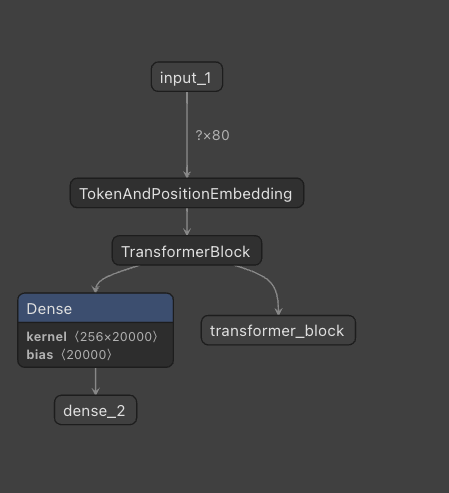

## Implement Text Generator Callback Object

In [54]:
class TextGenerator(keras.callbacks.Callback):
    """
    A callback to generate text from a trained model at the end of each epoch. It uses the model's 
    predictions to sample a token, add it to the input, and generate subsequent tokens.

    Attributes:
        max_tokens (int): The number of tokens to be generated after the prompt.
        start_tokens (list): The token indices for the starting prompt.
        index_to_word (list): Mapping from token indices to words, obtained from the TextVectorization layer.
        k (int): Number of token predictions to consider for sampling the next token.
        print_every (int): Frequency of print for the generated text (in number of epochs).
    """
    def __init__(self, max_tokens, start_tokens, index_to_word, top_k=20, print_every=1):
        """
        Initializes the TextGenerator callback.

        Args:
            max_tokens (int): Maximum number of tokens to be generated.
            start_tokens (list): List of integers representing the starting tokens.
            index_to_word (list): List of strings representing the mapping from indices to words.
            top_k (int, optional): Number of top token predictions to sample from. Defaults to 10.
            print_every (int, optional): Frequency of print (in number of epochs). Defaults to 1.
        """
        super().__init__()
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.k = top_k
        self.print_every = print_every
        self.generated_texts = [] # for qualitative validation set

    def sample_from(self, logits):
        """
        Sample a token index from the token predictions based on their probabilities.

        Args:
            logits (tf.Tensor): The token predictions (logits) of the model.

        Returns:
            int: The sampled token index.
        """
        # Select top-k logits and their indices
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")

        # Apply softmax to transform logits into probabilities
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")

        # Randomly select an index according to the probability distribution
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        """
        Convert a token index into the corresponding word.

        Args:
            number (int): The token index.

        Returns:
            str: The corresponding word.
        """
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        """
        At the end of each epoch, generate text and print it.

        Args:
            epoch (int): The current epoch number.
            logs (dict, optional): Dictionary of metrics from the epoch. Defaults to None.
        """
        # Create a copy of start tokens for generation
        start_tokens = [_ for _ in self.start_tokens]

        # Only generate text at specified frequency
        if (epoch + 1) % self.print_every != 0:
            return

        num_tokens_generated = 0
        tokens_generated = []

        # Generate tokens until max tokens reached
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1

            # Adjust padding based on length of start tokens
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens

            x = np.array([x])

            # Use the model to predict the probabilities for the next token
            y, _ = self.model.predict(x)

            # Sample a token from the model's output distribution
            sample_token = self.sample_from(y[0][sample_index])

            # Append the token to the list of generated tokens
            tokens_generated.append(sample_token)

            # Add the token to the start tokens for the next generation
            start_tokens.append(sample_token)

            # Increase the number of tokens generated by 1
            num_tokens_generated = len(tokens_generated)

        # Convert the tokens into actual words and join them into a string
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        
        self.generated_texts.append((epoch, txt)) # Store for evalutation after training


        # Print the generated text
        print(f"generated text:\n{txt}\n")

## Create Word/Index Mapping Dictionary 

In [55]:
## Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

## Initialize Callback Object

***We also need to supply a starting prompt to act as a qualitative validation set to evaluate the models performance from a 'does it make more sense' per epoch. It will generate(predict) a text sequence continuation from the starting prompt at the end of every epoch to inspect.***

In [56]:
start_prompt = "I would have"

start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 42
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

# Training

***I apologize for the scrolling your about to do. I wanted to generate text at each epoch so that along with loss there would be some qualitative evaluation on the models performance throughout training but I could not find a way to remove the progress bars for each step inside the epochs... If anyone reading this knows a way please comment.***

***Until about `25` epochs many of the generations depending on the satrting prompt during training had nonsensical outputs. So we will use `25` to get a good baseline model to evaluate.***

In [ ]:
model = MiniGPT()

N_EPOCHS = 25
history  = model.fit(text_ds, verbose=0, epochs=N_EPOCHS, callbacks=[text_gen_callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80)]              0         
                                                                 
 token_and_position_embeddin  (None, 80, 256)          7700480   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 80, 256)          658688    
 ormerBlock)                                                     
                                                                 
 dense_5 (Dense)             (None, 80, 30000)         7710000   
                                                                 
Total params: 16,069,168
Trainable params: 16,069,168
Non-trainable params: 0
_______________________________________________

## Evaluate Training Loss Per Epoch

In [ ]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

## Evaluate Validation Set Per Epoch

***Since we don't have a quantitative validation set in this situation we can use a qualitative validation set. These would be the generated text from the end of each epoch. This can give us some clues along with the losses per epoch to see how the models performance progressed through training.***

***Lets inspect what the first five generations look llike compared to the last five during training.***

In [ ]:
# for epoch, text in text_gen_callback.generated_texts:
#     print(f"Epoch: {epoch+1}\nGenerated Text:\n{text}\n")
    # Create a DataFrame
    
df_val = pd.DataFrame(text_gen_callback.generated_texts, columns=['Epoch', 'Generated Text'])

display(df_val.head(5));df_val.tail(5)

***It appears to that with more iterations the model becomes more and more realistic in its generations. The model starts producing less unknown tokens over time during training iterations.***

## Inference

***Now that we have trained the model to generate toxic comments from a starting prompt we can begin to generate our synthetic data.***

In [ ]:
def generate_text(starting_prompt=''):
    new_start_prompt = "here we"
    new_start_tokens = [word_to_index.get(word, 1) for word in new_start_prompt.split()]

    text_gen_callback.start_tokens = new_start_tokens
    text_gen_callback.on_epoch_end(0)

In [ ]:
generate_text("you sure")

# Conclusion

## State of training data

* I learned alot on this project. It is interesting to me that with all of the data in the world there is still a shortage of industrial sized, cleaned, organized, and labeled training data. 

* It would seem that allthough in academia the glory goes to the next new model or algorithm when really the training data is probably more important at this point. It does not matter how fancy an algorithm is(some of them are pretty fancy) or a model is, without good training data we are limited in the problems we can tackle effectively.

* During this project I researched training data sets and where they come from. Most of the open source ones come from a handful of instituions namely universities with a few corporations willing to share the training datasets or models which would not effect their market share significantly releasing them.

* Even the sensitive subjetcs such as the language used in this projects training data is very important to solve very prominent problems we have.

## Decisions made along the way
* I started off this project trying to adapt a GAN to acheive this tast but there is little work done in this area and I had a lot of trouble trying to implement one of the papers where they achieve this task.

* I chose this method as this model is lightweight and quick to train and tune for any specific style of language. As I mentioned at the beginning I originally tested this capabillity on the movie lines IMDB dataset and had great results. 

* The dataset I used turned out to be admittedly smaller than probably needed to get better results but I am confident that once I wrange up more nasty online comments the model will do much better after retraining.

* The feature dimensions in the attention head made a huge difference on training time and performance. I had better results at 512 than it is currently at (256) but the time to train 25 epochs grew exponentially. If I had more Kaggle GPU hours I would have done my final training round with 512 in the attention head.

* I originally tried a custom learning rate optimizing function but because of the large differences in epochs I was trying for different experiments I switched over to just using ADAM for this task.

* The starting prompt matters. I found out that after looking at the popular bigrams and trigrams if I chose those sequences the model would generate sensible text more easily. 

* The length of the starting prompt also effects how different each output is dramatically.

## Whats Next

* I am going to run this model and compile a set of generated texts which are known to be toxic and add them to the training set and retrain the BERT based model I used when competing in this competition to see what results I get with the added training data.


### Save and load model for future use

In [ ]:
model_path = '../working/Toxic_MiniGPT.h5'

# Save the model
model.save(model_path)

## Load the model
from tensorflow.keras.models import load_model

# Register the custom layer
tf.keras.utils.get_custom_objects()['TransformerBlock'] = TransformerBlock

# Load the model
model = load_model(model_path)